# 개요
* 참여중인 데이터 엔지니어링 스터디에서 배우는 내용 정리
  * 데이터 수집, 정제 : pyspark, airflow
  * 저장 : elasticsearch
  * 시각화 : kibana

# 5주차 과제리뷰

## Airflow

* Dag작성 샘플
  * spark-submit.sh 스크립트 파일을 Bash operator로 사용
  * gharchive의 변동 등으로 인한 사항을 적용 후 직접돌리기 위해 catchup=False
  ```python
    from airflow import DAG
    from airflow.operators.bash_operator import BashOperator

    from datetime import datetime, timedelta


    default_args = {
        "owner": "airflow",
        "depends_on_past": False,
        "start_date": datetime(2024, 6, 26),
        "retries": 1,
        "retry_delay": timedelta(minutes=2),
        # "on_failure_callback": ,
    }

    dag = DAG("github-archive-pipeline", 
            default_args=default_args, 
            max_active_runs=1, 
            schedule_interval="30 0 * * *", 
            catchup=False, 
            tags=['data'])

    dt = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
    download_data = BashOperator(
        task_id='download-data',
        bash_command=f"/opt/airflow/jobs/download-data.sh {dt} ",
        dag=dag
    )

    filename = '/opt/airflow/jobs/main.py'
    filter_data = BashOperator(
        task_id='filter-data',
        bash_command=f'/opt/airflow/jobs/spark-submit.sh {filename} ',
        dag=dag
    )

    download_data >> filter_data
  ```

# 6주차 수업정리

## Kibana

* Data Visualization
  * 데이터에 따라 적합한 시각화가 다름
  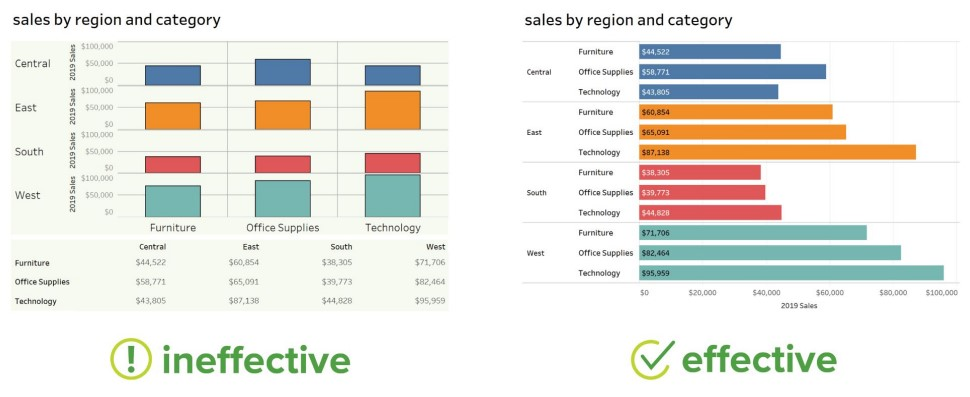
  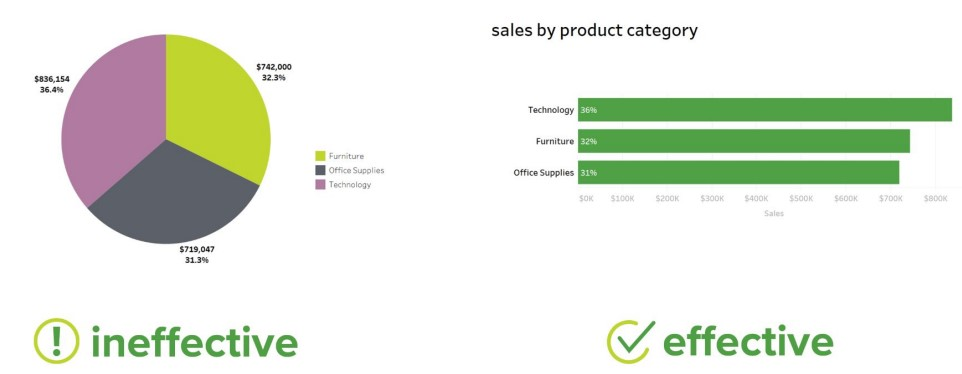
<br>

* 다양한 시각화 툴
  * Tableau
    * 유료 툴. ai 등 여러기능이 있으며 무거움
    * 교육 등이 활성화되어 있음
  * HighCharts
    * 가볍게 1회성으로 작성시 활용가능
  * Power BI
    * Tableau와 사용성이 비슷한 Windows툴
  * Google Chart
    * 온라인으로 사용가능한 기본차트 제공
  * D3.js, Chart.js
    * 자유도가 높은 라이브러리 (Javascript library)
    * Javascript이므로 웹에서 데이터 렌더링할 때 사용
    * 실시간반영가능, Interactivity
    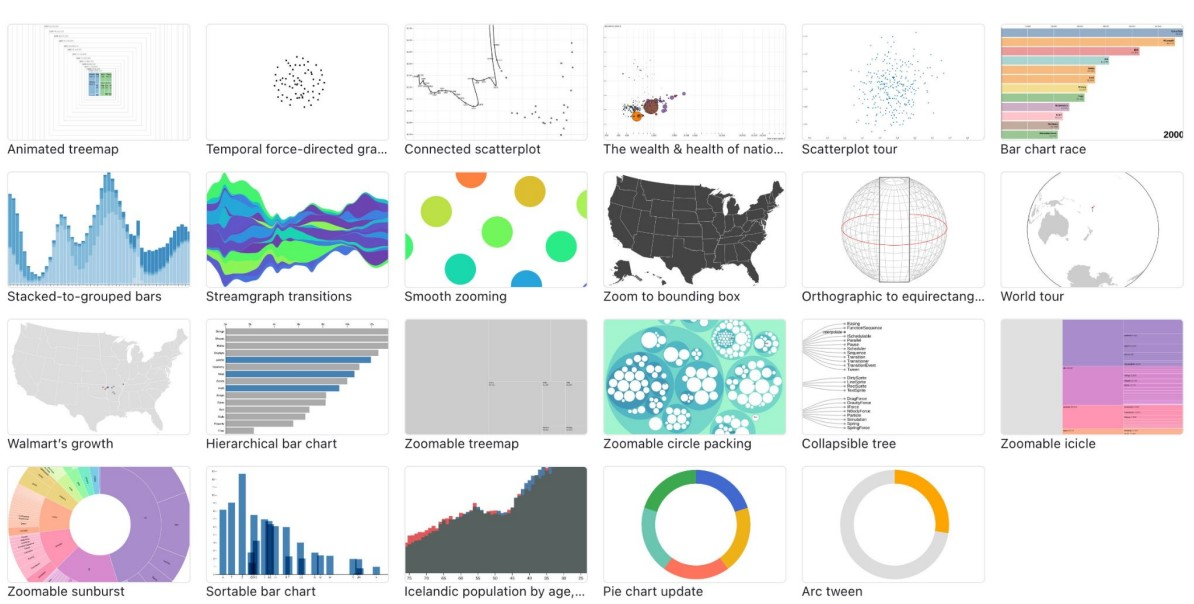
  * Grafana
    * 보통 클라우드의 모니터링을 위해 많이 사용
    * 서버 모니터링에 특화(Conetivity 등)  
  * Kibana
    * ES에 데이터를 전송하면, Kibana에 자동반영
<br>

* Kibana 장단점
  * 장점
    * Elasticsearch 시스템 모니터링, 검색 성능 평가에 탁월
      * ES와 세트로 만들어져있으며, 별도의 import등이 필요 없음
    * 다양한 visualization 생성, 인사이트 발굴 가능
    * 데이터 검색/탐색 + (데이터 쌓이는 것)모니터링 + 분석을 하나의 UI 에서 진행
    * visualization의 다양성과 interactivity 가 떨어짐
  * 단점
    * Elasticsearch 특화
    * plugin 설치가 번거로움
    * 잦은 Elasticsearch 버젼업에 따라가기 버거움
      * 항상 ES와 Kibana의 버전을 같이 써야함
<br>

* Kibana 기타
  * Observability
  * Security
  * Discover
  * Management - Index Patterns, Saved Object생성, Dev tool 등

* Kibana 세팅
```
services:
  kibana:
    image: docker.elastic.co/kibana/kibana:8.4.3 # ES와 버전 맞추기
    networks:
      - default-network
    environment:
      - SERVERNAME=kibana
      - ELASTICSEARCH_HOSTS=http://es:9200
      - ELASTICSEARCH_USERNAME=kibana
      - ELASTICSEARCH_PASSWORD=password
    ports:
      - 5601:5601  # 로컬포트:컨테이너포트
    depends_on:
      - es
```
<br>

* Kibana Manual install
  * https://www.elastic.co/guide/en/kibana/current/install.html

## Kibana 사용실습(Discover, Visualize Library, Dashboard)

* Discover
  * 기본화면
    * 좌측상단 Create data view
      * Name : 원하는 이름 지정
      * Index pattern : 사용할 index. daily-stats-*과 같이 와일드카드 가능
      * Timestamp : @timestamp를 기본으로 쓰나 다른 필드로 변경할 수 있다
    * 좌측상단 Add filter (`+`버튼)
      * +버튼을 눌러 UI로 필터링 가능
    * 좌측 Selected/Available fields
      * Selected로 필드추가하여 테이블 형태로 볼 수 있다
    * 상단 Visualization type
      * 그래프 타입 선택 가능
      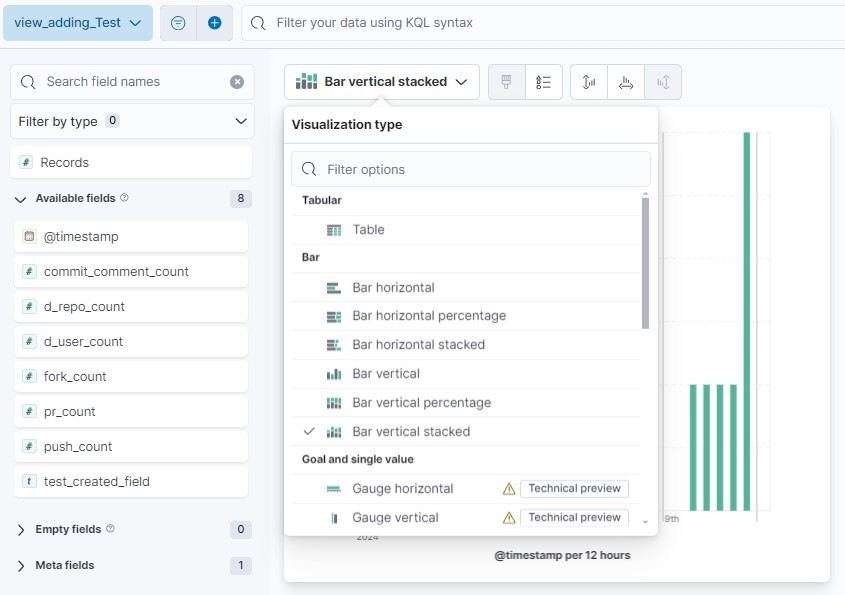
    * 상단 Documents
      * 그래프 막대를 클릭하여 해당일자만 조회 가능
    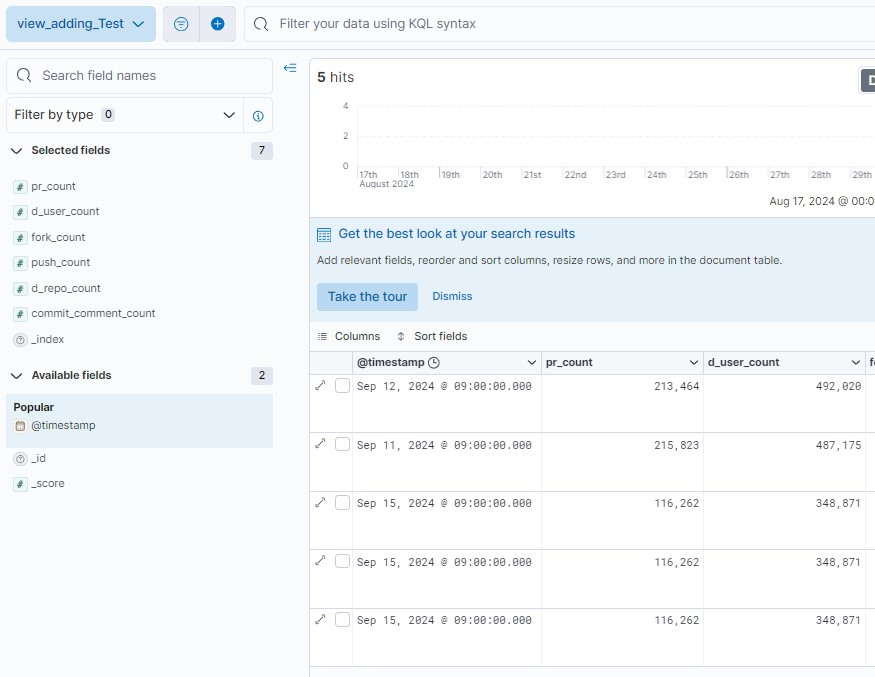
  * Create field
    * 타 필드에서 산출가능하다면 데이터를 최소로 저장하고 필드추가(Script Field생성)하는 방법이 있음
    * 좌측상단 Create field
      * Name지정 및 아래와 같이 script로 계산가능
      ```
        if (doc['fork_count'].size() != 0){
            return doc['fork_count'].value + 1;
        }
      ```
    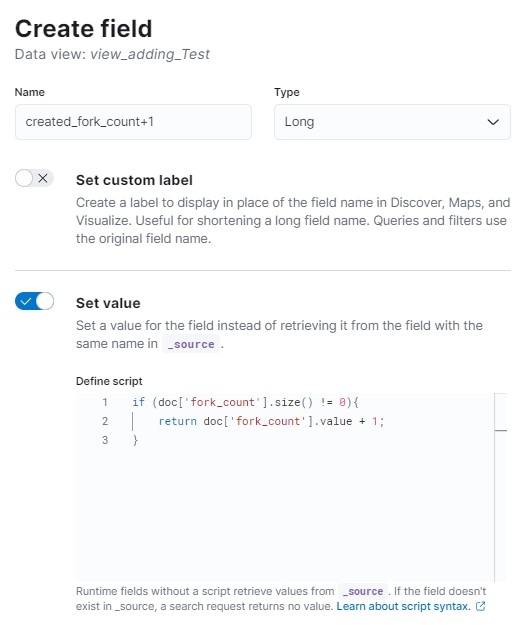
  * Discover에서 값을 확인하다가, 필드클릭 후 Visualize로 이동하여 보는 경우 많음
<br>

* Visualize Library
  * 종류
    * Lens : 그래프 등 기본 시각화
    * Maps : 지도 위에 시각화
    * TSVB : TSVB로 들어간 series data를 위한 기능
    * Custom visualization : Script로 시각화
  * Lens 실습
    * Create - Lens로 진입한 후  좌측상단에서 view를 선택. 
    * 추천하는 시각화로 표현되어 있음
    * 하단의 Suggestions의 시각화이며, 교체도 가능
  * 우측에서 대상 필드 및 Median, Average등 가능
  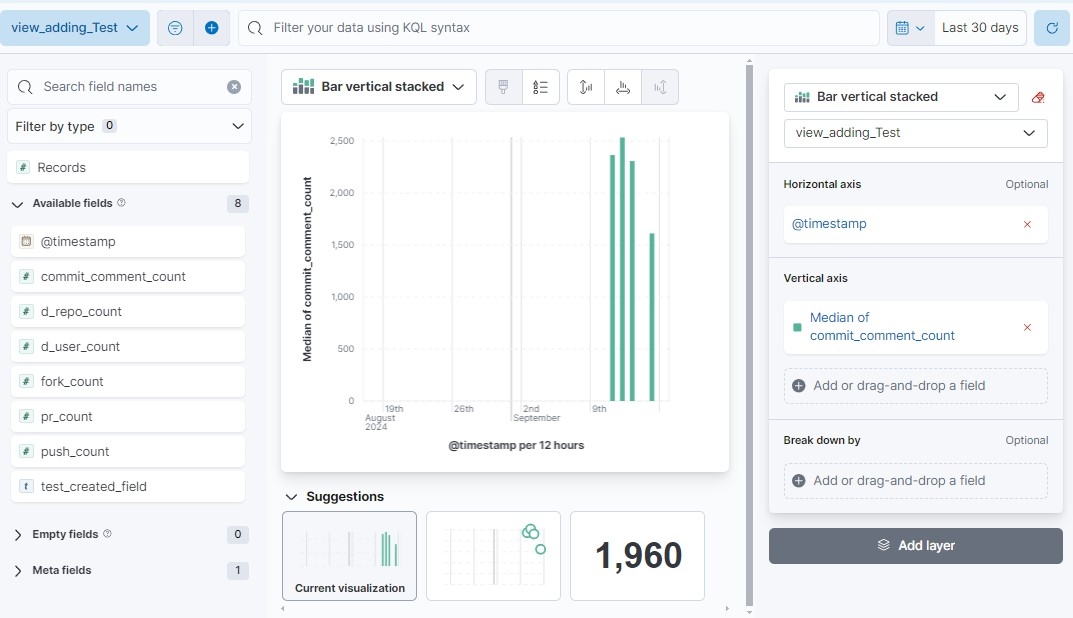
<br>

* KQL 샘플
  * Filter ratio example
    ```
    count(kql='response.status_code > 400') / count()
    ```
  * Week over week example (previous week : `shift='1w'`)
    * 서로 다른 단위는 연산 불가
    ```
    percentile(system.network.in.bytes, percentile=99) /
    percentile(system.network.in.bytes, percentile=99, shift='1w')
    ```
  * Percent of total example
    ```
    sum(products.base_price) / overall_sum(sum(products.base_price))
    ```
<br>

* Dashboard
  * 만들어 둔 Visualization 또는 새로 생성하여 구성 가능
  ![class_w6-8.jpg](attachment:class_w6-8.jpg)

## Kibana 기타

* Painless lab
  * Management - Devtools - Painless lab
    * 필드 추가 등을 직접하다가 오류나는 경우, Elastic search가 멈출 수 있고 실제 서비스라면 문제될 수 있음
      * Script field :     * ES field에 없는 값을 kibana에서 사용하고 싶을 때 생성할 수 있는 필드
    * Painless lab에서 테스트하면 위와 같은 경우를 방지할 수 있음
  * 샘플코드 (필드추가)
    ```
    GET /_search
      {
          "query" : {
              "match_all": {}
          },
          "script_fields" : {
              "필드명1" : {
                  "script" : {
                      "lang": "painless",
                      "source": "doc['price'].value * 2"             }
              },
                      }    }
    ```


## 기타 참고자료

* Kibana Demo (샘플데이터로 시각화해보기)
  * [https://demo.elastic.co/cookie/index.html?goto=%2F](https://demo.elastic.co/cookie/index.html?goto=%2F)
* D3 Best practice
  * [https://observablehq.com/collection/@observablehq/featured-creators](https://observablehq.com/collection/@observablehq/featured-creators)
* 상황별 시각화
  * [https://medium.com/@abdallahashraf90x/how-to-choose-the-right-visualization-for-your-data-data-analysis-c49b1469a583](https://medium.com/@abdallahashraf90x/how-to-choose-the-right-visualization-for-your-data-data-analysis-c49b1469a583)
* Kibana 스크립트 필드에서 Painless 사용
  * [https://www.elastic.co/kr/blog/using-painless-kibana-scripted-fields](https://www.elastic.co/kr/blog/using-painless-kibana-scripted-fields)